In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from src.numpy_encode import *
from src.utils.file_processing import process_all, process_file
from src.config import *
from src.music_transformer import *
from src.multitask_transformer import *

In [4]:
from fastai.text import *

## Example notebook explaining how to encode midi to numpy array and train with fastai

Numpy format 

In [5]:
data_path = Path('data')

# Location of your midi files
midi_path = data_path/'midi'
midi_path.mkdir(parents=True, exist_ok=True)

# Location of transformed midi to numpy dataset
numpy_path = data_path/'numpy'/'combined_tracks'
numpy_path.mkdir(parents=True, exist_ok=True)

s2s_path = data_path/'numpy'/'split_melody_chord'
s2s_path.mkdir(parents=True, exist_ok=True)

data_save_name = 'multi_data_idxenc.pkl'
s2s_data_save_name = 'multi_data_s2s.pkl'

## 1. Gather midi dataset

Make sure all your midi data is in `musicautobot/data/midi` directory

Here's a pretty good dataset with lots of midi data:  
https://www.reddit.com/r/datasets/comments/3akhxy/the_largest_midi_collection_on_the_internet/

Download the folder and unzip it to `data/midi`

### 2. Encode midi files to numpy

For more in customized encoding - see `notebooks/dataformatting/2-DataFormatting-AllCombined-X.ipynb`

In [6]:
midi_files = get_files(midi_path, '.mid', recurse=True); len(midi_files)

18

In [7]:
def npenc_tfm(midi_file):
    try:
        npenc = midi2npenc(midi_file)
    except Exception as e:
        print('Could not encode to file:', midi_file, e)
        return None
    
    if not is_valid_npenc(npenc, input_path=midi_file):
        return None
    
    return npenc

In [8]:
process_func = partial(process_file, tfm_func=npenc_tfm, src_path=midi_path, dest_path=numpy_path)

In [9]:
processed = process_all(process_func, midi_files, timeout=50); processed[:2]

[PosixPath('data/numpy/combined_tracks/examples/Levels - Avicii - Verse.npy'),
 PosixPath('data/numpy/combined_tracks/examples/Colors Of The Wind - Disney - Chorus.npy')]

## 3. Create dataset from encoded files

In [10]:
vocab = MusicVocab.create()
processors = [OpenNPFileProcessor(), IndexEncodeProcessor(vocab=vocab), PositionProcessor()]

data = MusicDataBunch.from_folder(numpy_path, processors=processors)
data.save(data_save_name)

## 3b. Encode sequence 2 sequence files

In [11]:
np.array(['a'])

array(['a'], dtype='<U1')

In [12]:
def s2s_tfm(midi_file):
    # Part 2. Compress rests and long notes
    stream = file2stream(midi_file) # 1.
    try:
        chordarr = stream2chordarr(stream) # 2. max_dur = quarter_len * sample_freq (4). 128 = 8 bars
    except Exception as e:
        print('Could not encode to chordarr:', midi_file, e)
        return None
    
    
    # Only 2 piano parts allowed
    _,num_parts,_ = chordarr.shape
    if num_parts != 2: return None
    
    # Individual parts must have notes
    parts = [part_enc(chordarr, i) for i in range(num_parts)]
    for p in parts: 
        if not is_valid_npenc(p, min_notes=8, input_path=midi_file): return None
        
    # order by pitch: assuming melody note > chords
    p1, p2 = parts
    m, c = (p1, p2) if avg_pitch(p1) > avg_pitch(p2) else (p2, p1) # Assuming melody has higher pitch
    
    return np.array([m, c])

In [13]:
s2s_process_func = partial(process_file, tfm_func=s2s_tfm, src_path=midi_path, dest_path=s2s_path)

In [14]:
processed = process_all(s2s_process_func, midi_files, timeout=50); processed[:2]

[PosixPath('data/numpy/split_melody_chord/examples/Levels - Avicii - Verse.npy'),
 PosixPath('data/numpy/split_melody_chord/examples/Colors Of The Wind - Disney - Chorus.npy')]

In [15]:
vocab = MusicVocab.create()
processors = [S2SFileProcessor(), S2SPartEncProcessor(vocab=vocab)]

s2s_data = MusicDataBunch.from_folder(s2s_path, processors=processors, preloader_cls=S2SPreloader)
s2s_data.save(s2s_data_save_name)

## 4. Load Model

In [18]:
batch_size = 2

msk_dl_tfms = [partial(mask_or_lm_tfm, p_mask=0.3, p_lm=1.0)]
lm_data = load_data(numpy_path, data_save_name, bs=batch_size)

c2m_dl_tfms = [partial(s2s_tfm, mlm_type=MLMType.C2M)]
s2s_data = load_data(s2s_path, s2s_data_save_name, bs=batch_size//2, preloader_cls=S2SPreloader)

NameError: name 'mask_or_lm_tfm' is not defined

In [ ]:
combined_data = 

In [25]:
config = mlm_config(data.vocab).copy(); config

{'ctx_len': 150,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': True,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'note_range': (9, 137),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 312,
 'enc_layers': 8,
 'dec_layers': 8}

In [20]:
model = get_language_model(TransformerXL, len(vocab.itos), config=config)
learn = MusicLearner(data, model, split_func=tfmerXL_lm_split)

In [21]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,3.636108,2.796926,0.327902,00:07
1,2.916940,2.495449,0.514286,00:07
2,2.686335,2.309064,0.514286,00:07
3,2.546277,2.453407,0.186384,00:07


## 5. Prediction time

In [22]:
midi_files = get_files(data_path, '.mid', recurse=True)
midi_file = midi_files[0]; midi_file

PosixPath('data/midi/examples/Levels - Avicii - Verse.mid')

In [24]:
idxenc = midi2idxenc(midi_file); idxenc.shape

(304,)

Only send a few notes 

In [25]:
# convert numpy encoding to torch tensor. 
seed_len = 100
seed = torch.from_numpy(idxenc)[:seed_len][None]; seed.shape

torch.Size([1, 100])

Here's what the seed sounds like:

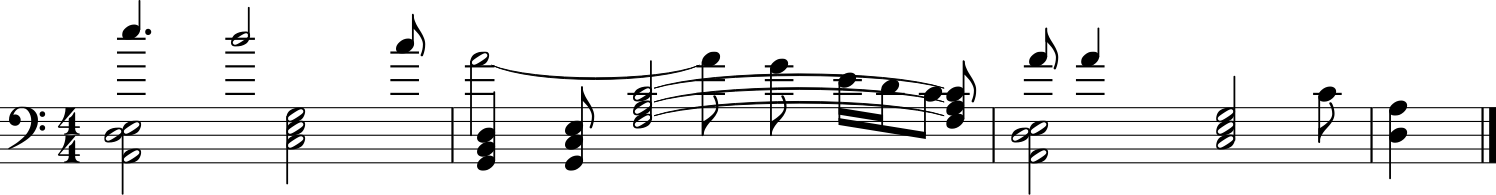

In [26]:
seed_stream = idxenc2stream(seed.cpu().numpy()[0])
seed_stream.show()

### Start Predictions:

In [28]:
out, seed = learn.predict(seed.cuda(), n_words=100)

Seed - used for prediction

Prediction

In [29]:
# Prediction
stream = idxenc2stream(out)
stream.show()

Non midi note detected. Only returning valid portion. Index, seed 3 (50, 2)


ValueError: negative dimensions are not allowed

In [ ]:
stream.show('midi')